This entry has borrowed many ideas from the following:
https://www.kaggle.com/code/mnassrib/titanic-logistic-regression-with-python/notebook

https://amueller.github.io/aml/01-ml-workflow/04-categorical-variables.html

https://towardsdatascience.com/stop-wasting-useful-information-when-imputing-missing-values-d6ef91ef4c21

https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


#Force pd to display print in full
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

train = pd.read_csv('train.csv')
#Random reshuffle of index to avoid possible implicit sorting
train = train.reindex(np.random.permutation(train.index))
test=pd.read_csv('test.csv')

Let's check the first few entries of data to get a feel of things.

In [3]:
print('Data head=','\n',train.head(),'\n')

Data head= 
      PassengerId  Survived  Pclass                                 Name  \
109          110         1       3                  Moran, Miss. Bertha   
583          584         0       1                  Ross, Mr. John Hugo   
185          186         0       1                Rood, Mr. Hugh Roscoe   
316          317         1       2  Kantor, Mrs. Sinai (Miriam Sternin)   
793          794         0       1             Hoyt, Mr. William Fisher   

        Sex   Age  SibSp  Parch    Ticket     Fare Cabin Embarked  
109  female   NaN      1      0    371110  24.1500   NaN        Q  
583    male  36.0      0      0     13049  40.1250   A10        C  
185    male   NaN      0      0    113767  50.0000   A32        S  
316  female  24.0      1      0    244367  26.0000   NaN        S  
793    male   NaN      0      0  PC 17600  30.6958   NaN        C   



Check if data is imbalanced.

In [4]:
print('Survived ratio=','\n',train['Survived'].value_counts()/train.shape[0],'\n')

Survived ratio= 
 0    0.616162
1    0.383838
Name: Survived, dtype: float64 



Check correlation to see features that are worth being selected.

In [5]:
print('Correlation=','\n',train.corr(method='kendall'),'\n')

Correlation= 
              PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.004090 -0.026824  0.027542 -0.048394  0.000798   
Survived       -0.004090  1.000000 -0.323533 -0.043385  0.085915  0.133933   
Pclass         -0.026824 -0.323533  1.000000 -0.286081 -0.039552 -0.021019   
Age             0.027542 -0.043385 -0.286081  1.000000 -0.142746 -0.200112   
SibSp          -0.048394  0.085915 -0.039552 -0.142746  1.000000  0.425241   
Parch           0.000798  0.133933 -0.021019 -0.200112  0.425241  1.000000   
Fare           -0.008921  0.266229 -0.573531  0.093249  0.358262  0.330360   

                 Fare  
PassengerId -0.008921  
Survived     0.266229  
Pclass      -0.573531  
Age          0.093249  
SibSp        0.358262  
Parch        0.330360  
Fare         1.000000   



Check the percentage of missing data.

In [6]:
print('Missing data summary=','\n',train.isna().sum()/train.shape[0],'\n')

Missing data summary= 
 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64 



Next we will use sns.pairplot() to do exploratory data analysis, but the plot can only handle a dataset with no missing data. So let's proceed to data imputation.

## Data Imputation

Age, Embarked and Cabin are missing data, but Cabin is missing >70% and the location of passengers are likely accounted for in Pclass anyway, therefore Cabin will be left out.

Age will be imputed and since only 0.002 of Embarked are missing, so dropping them is the easiest approach.

In [7]:
#Dropping missing Embarked entries
train=train.dropna(subset=['Embarked'])

Age is correlated with other features, i.e. SibSp, Parch, Fare therefore imputing with mean/median would have ignored this fact and may disrupt the original distribution, here IterativeImputer will be used instead.

In [8]:
#Imputing Age for train and test
numeric_features=['Age','SibSp','Parch','Fare']
data_for_imp=train[numeric_features]
imp=IterativeImputer()
data_for_imp[:]=imp.fit_transform(data_for_imp)
train['Age']=np.round(data_for_imp['Age'])

data_for_imp_test=test[numeric_features]
imp_test=IterativeImputer()
data_for_imp_test[:]=imp_test.fit_transform(data_for_imp_test)
test['Age']=np.round(data_for_imp_test['Age'])

C:\Users\Pixy_33\AppData\Local\Temp/ipykernel_9088/3401642975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_imp[:]=imp.fit_transform(data_for_imp)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Pixy_33\AppData\Local\Temp/ipykernel_9088/3401642975.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Now that missing datas have been imputed, we are ready to do exploratory data analysis using sns.pairplot().

<Figure size 432x288 with 0 Axes>

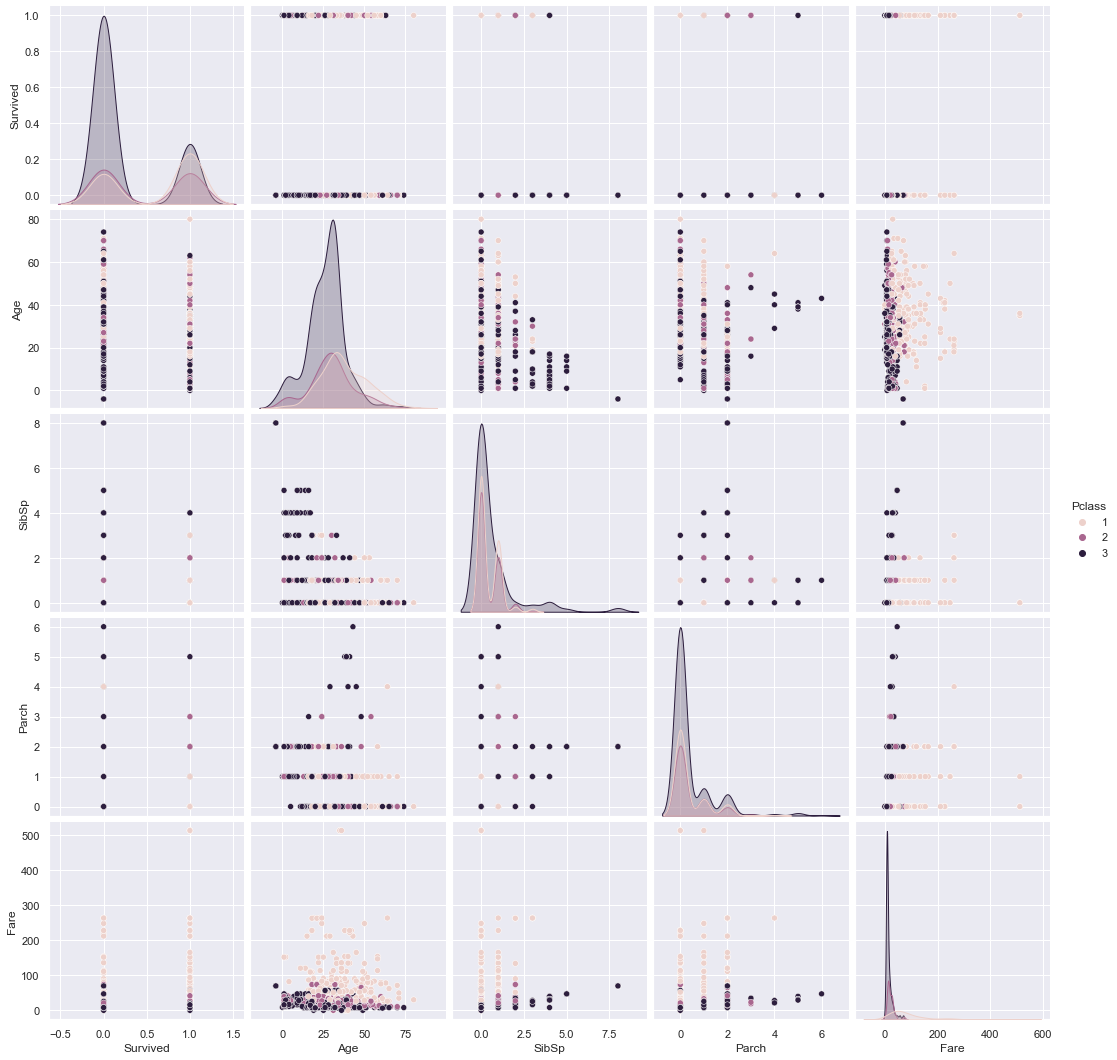

<Figure size 432x288 with 0 Axes>

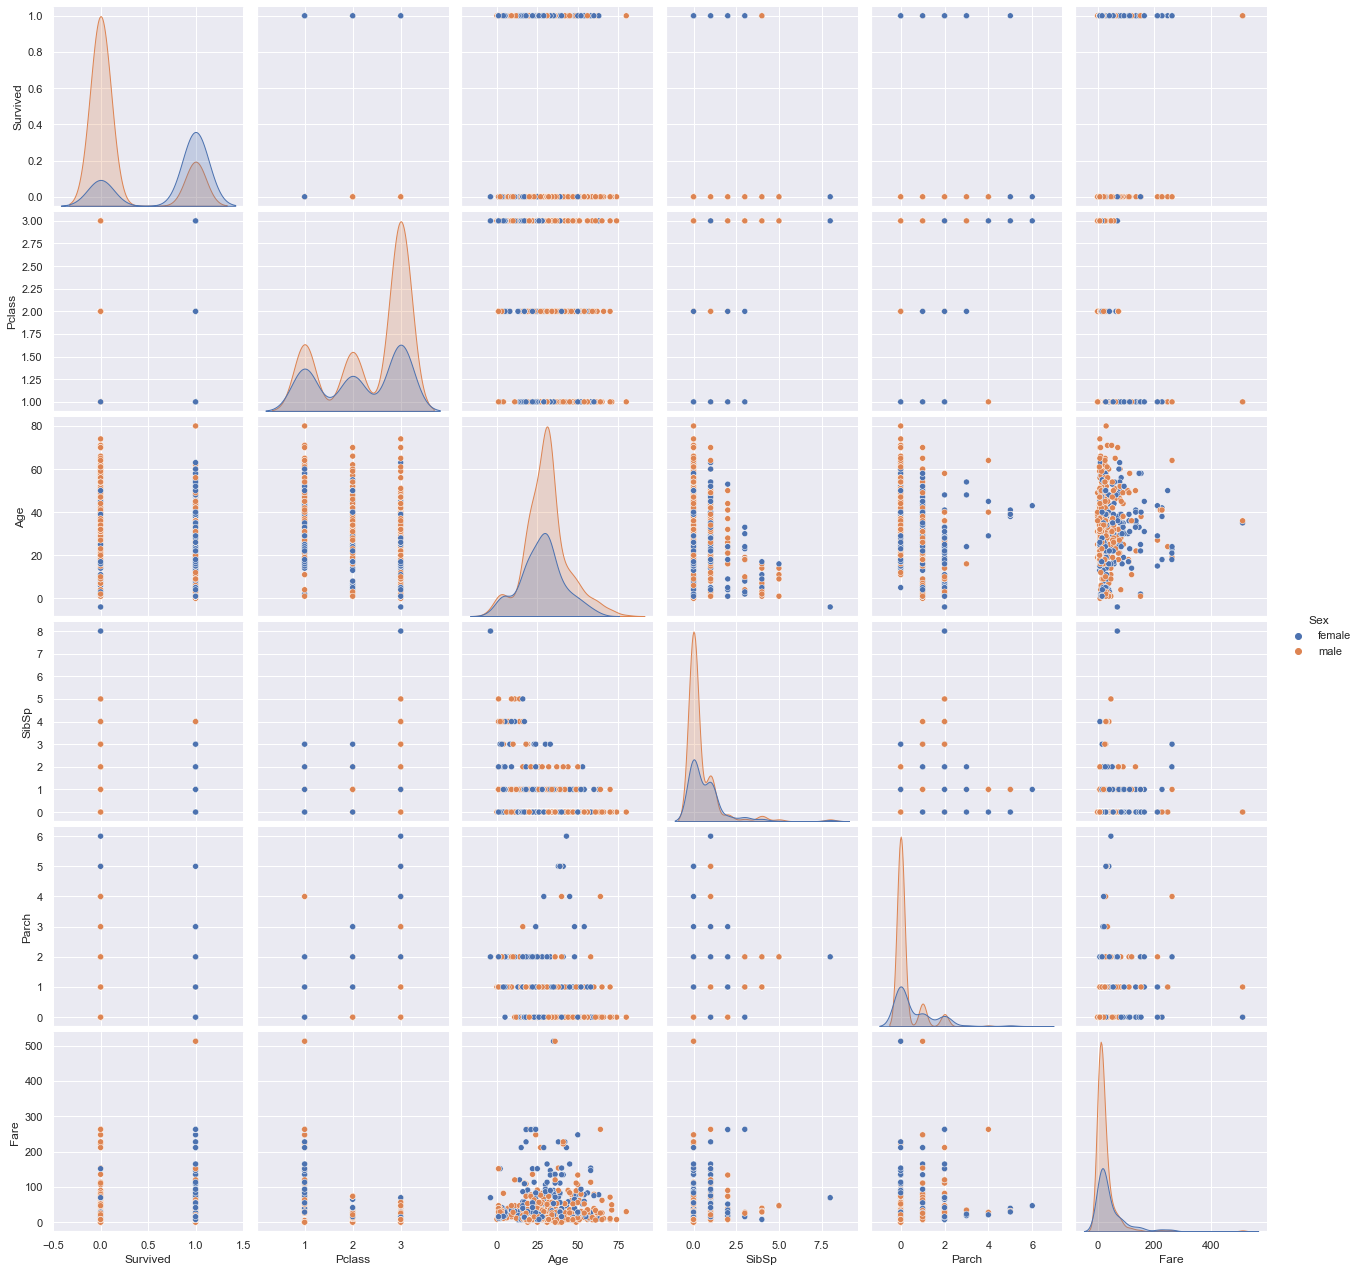

<Figure size 432x288 with 0 Axes>

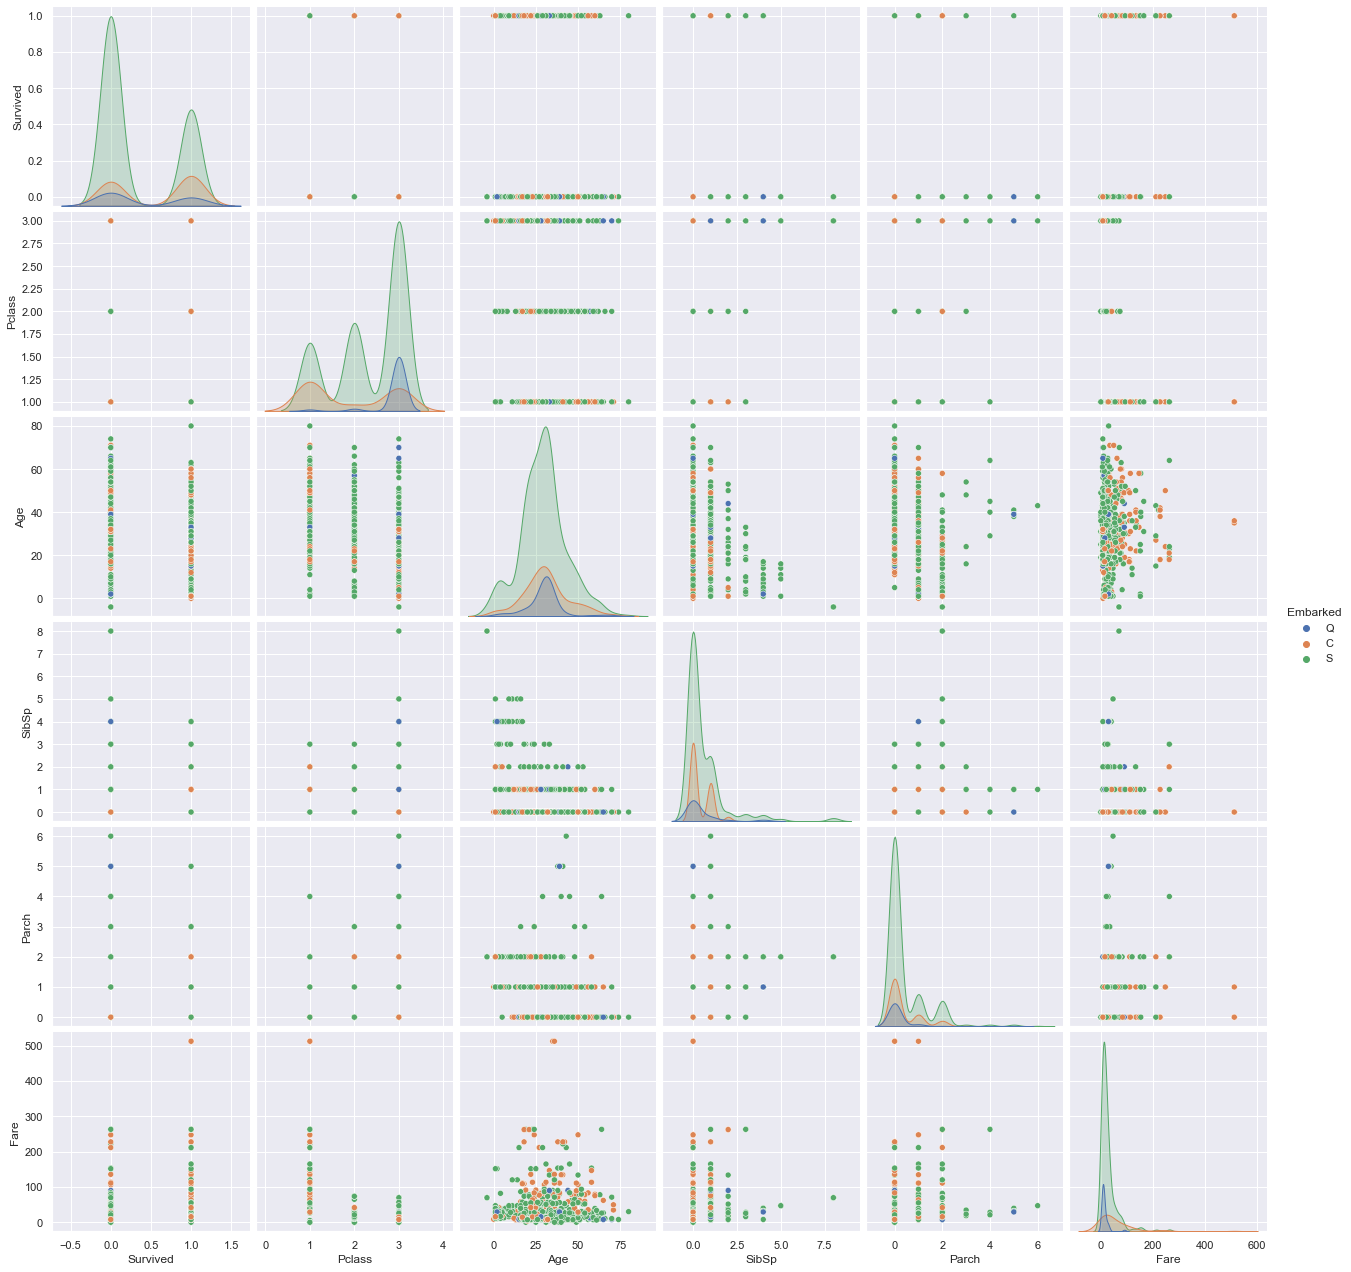

In [9]:
cat_cols_pair = ['Pclass', 'Sex','Embarked']
cols_2_pair = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

for col in cat_cols_pair:
    sns.set()
    plt.figure()
    sns.pairplot(train[cols_2_pair], height=3.0, hue=col)
    plt.show()

A few observations from the pairplot:
- 3rd class passengers are much more likely to die (1st plot)

- Female are clearly more likely to have survived (2nd plot)

- For those who embarked in Southampton, their chances of survival are lower than that of those who embarked elsewhere, as there are more deceased than survived Southampton passengers (3rd plot)

One hot encoding Embarked, Sex and Pclass, the latter has values between 1-3 so treating it as numeric feature may mislead the model to treat the values as weight.

In [10]:
train=train.dropna(subset=['Embarked'])
ohe=OneHotEncoder(sparse=False)
ohe_data=train[['Pclass','Sex','Embarked']]
train_ohe=(ohe.fit_transform(ohe_data)).astype(int)
train_ohe = pd.DataFrame(train_ohe,columns=ohe.get_feature_names(ohe_data.columns),index=ohe_data.index)
train=pd.concat([train,train_ohe], axis=1)

#One hot encoding relevant columns in test
ohe_test=OneHotEncoder(sparse=False)
ohe_test_data=test[['Pclass','Sex','Embarked']]
test_ohe=(ohe_test.fit_transform(ohe_test_data)).astype(int)
test_ohe = pd.DataFrame(test_ohe,columns=ohe_test.get_feature_names(ohe_test_data.columns),index=ohe_test_data.index)
test=pd.concat([test,test_ohe], axis=1)

It is suspected that children and teenagers were prioritised to board lifeboats. A visualisation is created to see if that is worth investigating.

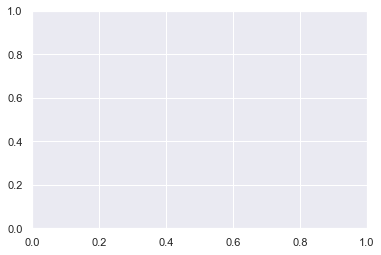

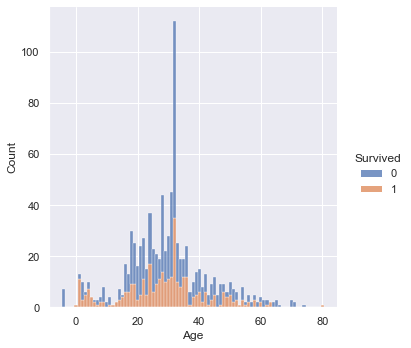

In [11]:
fig, ax = plt.subplots()
sns.displot(train,x='Age',hue='Survived',multiple="stack", discrete=True)
plt.show()

It seems that those who were under 16y/o were more likely to have survived. Creating a feature identifying passengers who are >16y/o.

In [12]:
train['Over 16']=(train['Age']>16).astype(int)
test['Over 16']=(test['Age']>16).astype(int)

We now pick the relevant features for modeling and separate out the target variable.

In [14]:
feature_cols = ['Over 16', 'Pclass_1','Pclass_2','Pclass_3','Sex_female','Embarked_C','Embarked_Q','Embarked_S']
#Features
X = train[feature_cols] 
#Target variable
y = train.Survived

We do a final check on the relevance of these categorical features by doing a chi-square test.

In [15]:
fs = SelectKBest(score_func=chi2, k='all')
X_fs = fs.fit_transform(X, y)
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 1.073010
Feature 1: 53.818827
Feature 2: 6.362914
Feature 3: 40.798666
Feature 4: 169.242305
Feature 5: 20.828558
Feature 6: 0.016705
Feature 7: 5.643887


So it turns out that actually 'Over 16' is not a very relevant feature, while features 1,3,4 and 5 are the most prominent.

Narrowing down selection of features based on chi square test.

In [16]:
feature_cols = ['Pclass_1','Pclass_3','Sex_female','Embarked_C']
#Features
X = train[feature_cols] 

In this project, logistic regression, random forest, and ensembling both will be tried and evaluated.

In [17]:
#Initiating the models
logreg = LogisticRegressionCV()
rfc = RandomForestClassifier()
vc=VotingClassifier([('clf1',logreg),('clf2',rfc)],voting='soft')

In [19]:
logreg_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print(logreg.__class__.__name__+" average accuracy is",logreg_accuracy.mean())

rfc_accuracy = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
print(rfc.__class__.__name__+" average accuracy is",rfc_accuracy.mean())

vc_accuracy = cross_val_score(vc, X, y, cv=10, scoring='accuracy')
print(vc.__class__.__name__+" average accuracy is" ,vc_accuracy.mean())

LogisticRegressionCV average accuracy is 0.7694203268641471
RandomForestClassifier average accuracy is 0.7817798774259448
VotingClassifier average accuracy is 0.772791113381001


Therefore it seems that ensembling yields the highest accuracy. Next we fine tune the hyperparameters to maximize performance.

In [20]:
#Fitting the models to generate prediction
logreg.fit(X,y)
rfc.fit(X,y)
vc.fit(X,y)

VotingClassifier(estimators=[('clf1', LogisticRegressionCV()),
                             ('clf2', RandomForestClassifier())],
                 voting='soft')

We will now use gridsearch to find the best set of parameters for random forest and voting classifier ensemble. Logistic regression has already been fine tuned with cross validation.

In [21]:
rfc_params={'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,6,7,8]}
grid_rfc=GridSearchCV(rfc,rfc_params)
grid_rfc.fit(X,y)
print('Best params for RF=',grid_rfc.best_params_)
rfc_best_params=grid_rfc.best_params_

vc_params={'voting':['hard','soft'],'weights':[(1,1),(2,1),(1,2)]}
grid_vc=GridSearchCV(vc,vc_params)
grid_vc.fit(X,y)
print('Best params for VC=',grid_vc.best_params_)
vc_best_params=grid_vc.best_params_


rfc_tuned=RandomForestClassifier(max_depth=rfc_best_params['max_depth'], 
                                 max_features=rfc_best_params['max_features'], 
                                 n_estimators=rfc_best_params['n_estimators'])
rfc_tuned.fit(X,y)
vc_tuned=VotingClassifier([('clf1',logreg),('clf2',rfc_tuned)],
                          voting=vc_best_params['voting'],
                          weights=vc_best_params['weights'])
vc_tuned.fit(X,y)

Best params for RF= {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
Best params for VC= {'voting': 'hard', 'weights': (1, 1)}


Finally, dropping columns so that column wise test_1 lines up with X.

In [ ]:
test_1=test[feature_cols]
test_pred=vc_tuned.predict(test_1)
test_1['PassengerId']=test['PassengerId']
test_1['Survived']=test_pred
test_1=test_1.drop(columns=feature_cols)
test_1.to_csv("Ensembled_Titanic_selectKbest.csv",index=False)